In [52]:
# Cell 1: Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
import time # To time the calibration

# Add the 'src' folder to the path
sys.path.insert(0, os.path.abspath('../src'))

# --- Import our tools ---
from data_fetcher.yfinance_fetcher import fetch_data
from calibration.gbm_calibrator import GbmCalibrator
from calibration.merton_calibrator import MertonCalibrator 

from models.gbm import GeometricBrownianMotion
from models.merton import MertonJumpDiffusion

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
print("All modules imported successfully.")

All modules imported successfully.


/media/harsh-vardhan-gupta/New Volume/Placement Prep/BTP/src/data_fetcher/yfinance_fetcher.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Fetching GOLDBEES.NS data from 2020-01-01 to 2024-12-31...
Data fetched successfully. 1237 data points.


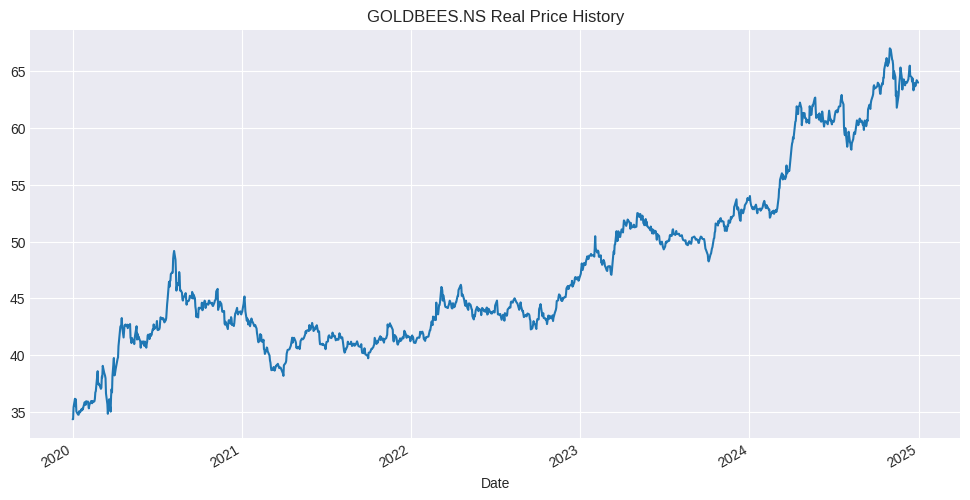

--- 1. Calibrating GBM (Baseline) ---
GBM calibration finished in 0.00 seconds.
GBM AIC: -8185.70
GBM Params: {'mu': np.float64(0.13665926531529676), 'sigma': np.float64(0.13990295083574125), 'S0': np.float64(34.349998474121094)}

--- 2. Calibrating Merton (Challenger) ---
NOTE: This may take 30-60 seconds...
Merton calibration finished in 0.25 seconds.
Merton AIC: -8398.41
Merton Params: {'mu': np.float64(0.13668025008565046), 'sigma': np.float64(0.08769965420668543), 'lambda_j': np.float64(68.63503958461685), 'mu_j': np.float64(-4.422350555317219e-05), 'sigma_j': np.float64(0.013178808910414494), 'S0': np.float64(34.349998474121094)}

--- 3. Final Model Comparison ---
        Log-Likelihood  # Params          AIC          BIC
Merton     4204.205557         5 -8398.411115 -8372.812936
GBM        4094.851742         2 -8185.703484 -8175.464213

--- Conclusion ---
🏆 The Merton model (AIC: -8398.41) is the WINNER!
Its score is lower than GBM (AIC: -8185.70).
This suggests the data *does*

In [53]:
# Cell 2: Fetch Real Data
ticker = 'GOLDBEES.NS' # Nippon India ETF Gold BeES
start = '2020-01-01'
end = '2024-12-31' 

print(f"Fetching {ticker} data from {start} to {end}...")
real_data = fetch_data(ticker, start, end)[ticker]

# Make sure data fetching worked
assert real_data is not None, "Data fetching failed! Check ticker or internet."
assert not real_data.empty, "Data is empty!"

print(f"Data fetched successfully. {len(real_data)} data points.")
real_data.plot(title=f"{ticker} Real Price History", figsize=(12, 6))
plt.show()

# Cell 3: Calibrate Model 1 (GBM - The Baseline)
print("--- 1. Calibrating GBM (Baseline) ---")
start_time_gbm = time.time()

# Create the calibrator (using 1/252 for daily data)
gbm_cal = GbmCalibrator(dt=1/252)

# Fit the model to the data
gbm_cal.fit(real_data)

end_time_gbm = time.time()

print(f"GBM calibration finished in {end_time_gbm - start_time_gbm:.2f} seconds.")
print(f"GBM AIC: {gbm_cal.get_aic():.2f}")
print(f"GBM Params: {gbm_cal.get_params()}")

# Cell 4: Calibrate Model 2 (Merton - The Challenger)
print("\n--- 2. Calibrating Merton (Challenger) ---")
print("NOTE: This may take 30-60 seconds...")
start_time_merton = time.time()

# Create the calibrator
merton_cal = MertonCalibrator(dt=1/252)

# Fit the model (with error handling)
try:
    merton_cal.fit(real_data)
    end_time_merton = time.time()
    print(f"Merton calibration finished in {end_time_merton - start_time_merton:.2f} seconds.")
    print(f"Merton AIC: {merton_cal.get_aic():.2f}")
    print(f"Merton Params: {merton_cal.get_params()}")
    merton_succeeded = True
except Exception as e:
    print(f"!!! MERTON CALIBRATION FAILED !!!")
    print(f"Error: {e}")
    merton_succeeded = False

# Cell 5: The Final Result - Model Comparison
print("\n--- 3. Final Model Comparison ---")

if not merton_succeeded:
    print("Cannot compare models, Merton calibration failed.")
else:
    # Build a comparison table
    results = {
        'Log-Likelihood': [
            gbm_cal.get_log_likelihood(),
            merton_cal.get_log_likelihood()
        ],
        '# Params': [
            gbm_cal.n_params,
            merton_cal.n_params
        ],
        'AIC': [
            gbm_cal.get_aic(),
            merton_cal.get_aic()
        ],
        'BIC': [
            gbm_cal.get_bic(),
            merton_cal.get_bic()
        ]
    }
    
    # Create the DataFrame
    results_df = pd.DataFrame(results, index=['GBM', 'Merton'])
    
    # Print the results, sorted by AIC (lowest is best)
    print(results_df.sort_values(by='AIC'))
    
    print("\n--- Conclusion ---")
    aic_gbm = gbm_cal.get_aic()
    aic_merton = merton_cal.get_aic()
    
    if aic_merton < aic_gbm:
        print(f"🏆 The Merton model (AIC: {aic_merton:.2f}) is the WINNER!")
        print(f"Its score is lower than GBM (AIC: {aic_gbm:.2f}).")
        print("This suggests the data *does* contain jumps ('fat tails')")
        print("and the extra 3 parameters were justified.")
    else:
        print(f"🏆 The GBM model (AIC: {aic_gbm:.2f}) is the WINNER!")
        print(f"Its score is lower than Merton (AIC: {aic_merton:.2f}).")
        print("This suggests the Merton model was 'overfitting'.")
        print("The extra complexity was not worth it for this dataset.")



--- 4. Plotting Calibrated Simulations ---
Simulating 1 paths for each model...


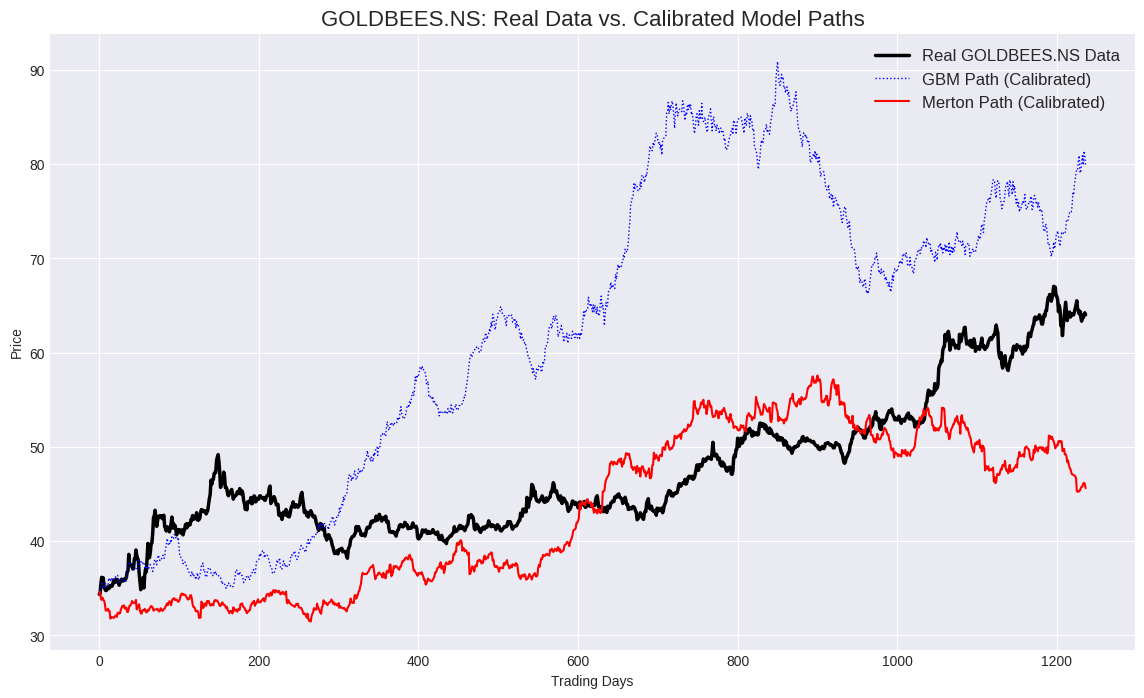

In [54]:
# Cell 6: Plot Calibrated Simulations
print("\n--- 4. Plotting Calibrated Simulations ---")

# 1. Get the calibrated parameters from our objects
params_gbm = gbm_cal.get_params()
params_merton = merton_cal.get_params()

# 2. Get the simulation time horizon from the data
T = (gbm_cal.n_obs) * gbm_cal.dt # (e.g., 730 obs * 1/252 dt)
dt = gbm_cal.dt
n_paths_to_plot = 1

# 3. Instantiate the models with the REAL parameters
model_gbm_calibrated = GeometricBrownianMotion(**params_gbm)
model_merton_calibrated = MertonJumpDiffusion(**params_merton)

# 4. Run new simulations
print(f"Simulating {n_paths_to_plot} paths for each model...")
paths_gbm = model_gbm_calibrated.simulate(T, dt, n_paths_to_plot)
paths_merton = model_merton_calibrated.simulate(T, dt, n_paths_to_plot)

# 5. Plot everything together
plt.figure(figsize=(14, 8))

# Plot the real data
# We need to reset the index to match the 0-based sim
real_data_plot = real_data.reset_index(drop=True)
plt.plot(
    real_data_plot, 
    color='black', 
    linewidth=2.5, 
    label=f"Real {ticker} Data"
)

# Plot the GBM paths
plt.plot(
    paths_gbm, 
    color='blue', 
    linestyle = 'dotted',
    linewidth=1.0,
    label="GBM Path (Calibrated)"
)

# Plot the Merton paths
plt.plot(
    paths_merton, 
    color='red', 
    linewidth=1.5,
    label="Merton Path (Calibrated)"
)

plt.title(f"{ticker}: Real Data vs. Calibrated Model Paths", fontsize=16)
plt.xlabel("Trading Days")
plt.ylabel("Price")

# Clean up the legend (to avoid duplicate labels)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=12)

plt.show()




--- 5B. Generating QQ-Plots for Real, GBM, and Merton Returns ---


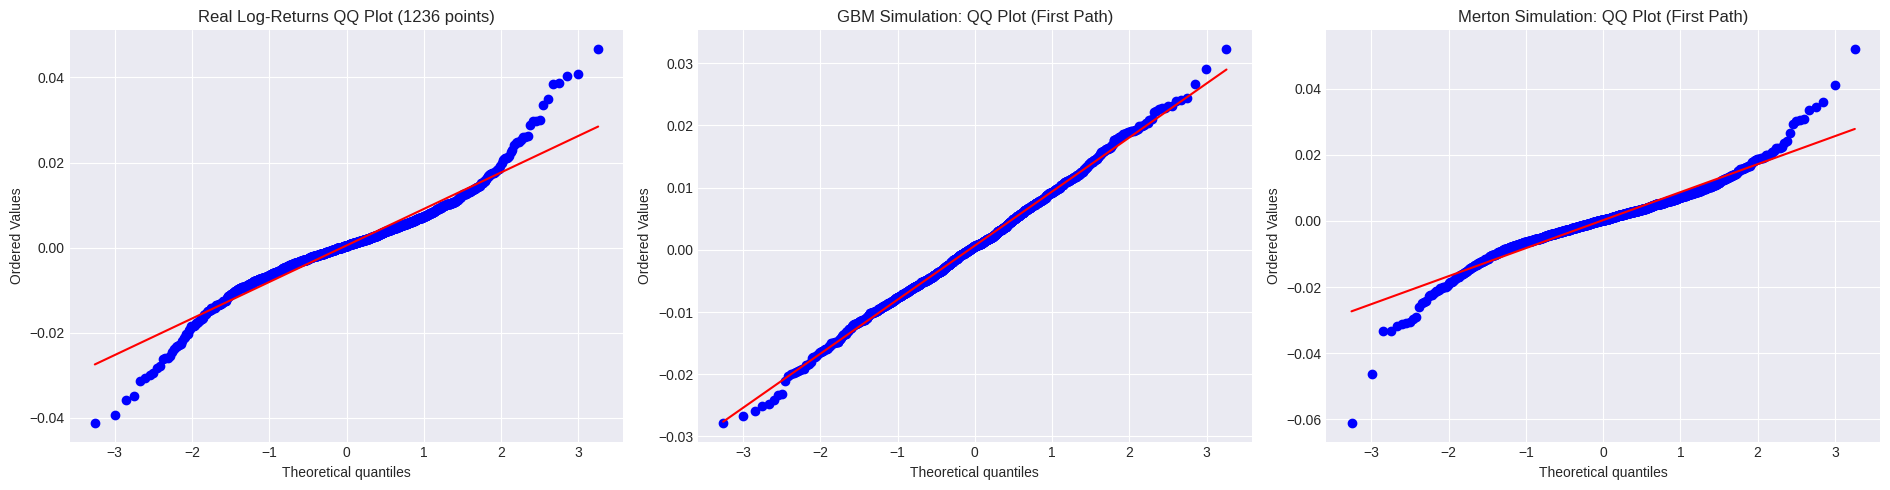

QQ-Plots generated successfully.


In [55]:
print("\n--- 5B. Generating QQ-Plots for Real, GBM, and Merton Returns ---")

# 1. Real log returns
real_returns = np.log(real_data / real_data.shift(1)).dropna()

# 2. Use only the FIRST path from each simulation
sim_gbm_prices = paths_gbm[:, 0]       # first column = first path
sim_merton_prices = paths_merton[:, 0] # first column = first path

# 3. Compute simulated log returns
sim_gbm_returns = np.log(sim_gbm_prices[1:] / sim_gbm_prices[:-1])
sim_merton_returns = np.log(sim_merton_prices[1:] / sim_merton_prices[:-1])

# 4. Plot the QQ-plots side-by-side
plt.figure(figsize=(19, 5))

# --- Real Data ---
plt.subplot(1, 3, 1)
stats.probplot(real_returns, dist="norm", plot=plt)
plt.title(f"Real Log-Returns QQ Plot ({len(real_returns)} points)")
plt.grid(True)

# --- GBM ---
plt.subplot(1, 3, 2)
stats.probplot(sim_gbm_returns, dist="norm", plot=plt)
plt.title("GBM Simulation: QQ Plot (First Path)")
plt.grid(True)

# --- Merton ---
plt.subplot(1, 3, 3)
stats.probplot(sim_merton_returns, dist="norm", plot=plt)
plt.title("Merton Simulation: QQ Plot (First Path)")
plt.grid(True)

plt.tight_layout()
plt.show()

print("QQ-Plots generated successfully.")


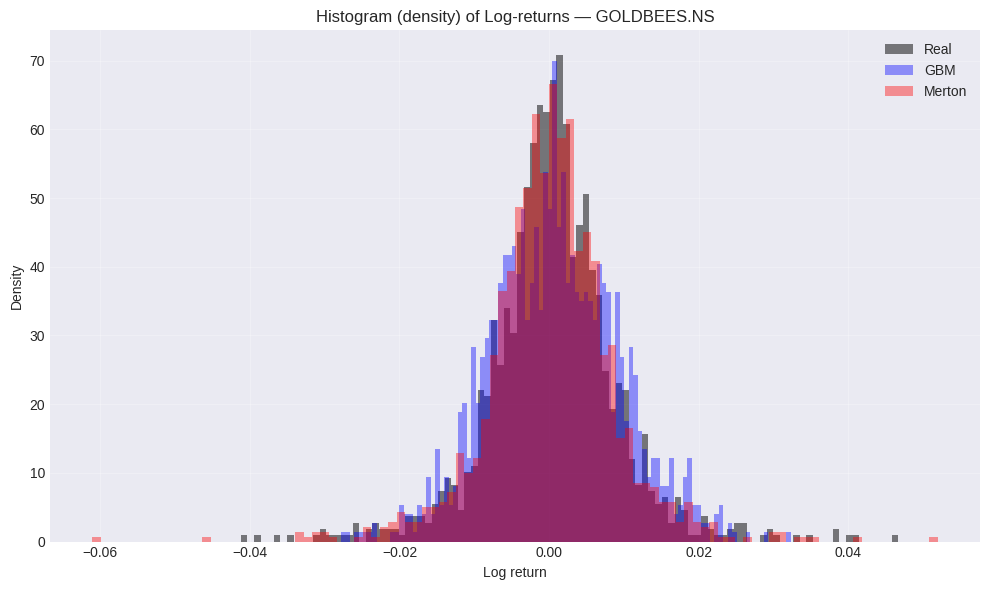

In [56]:
# New cell: Histogram (density) of log-returns for Real, GBM and Merton
import numpy as np
import matplotlib.pyplot as plt

# Use already-computed arrays if available, otherwise compute them
real_series = real_data.reset_index(drop=True).astype(float)
lr_real = np.log(real_series).diff().dropna().values

def first_path(arr):
    a = np.asarray(arr)
    if a.ndim == 1:
        return a
    if a.ndim == 2:
        if a.shape[1] >= 1 and a.shape[0] > a.shape[1]:
            return a[:, 0]
        else:
            return a[0, :]
    return a.flatten()

sim_gbm = first_path(paths_gbm)
sim_merton = first_path(paths_merton)
lr_gbm = np.diff(np.log(sim_gbm))
lr_merton = np.diff(np.log(sim_merton))

bins = 100
plt.figure(figsize=(10,6))
plt.hist(lr_real, bins=bins, density=True, alpha=0.5, label='Real', color='black')
plt.hist(lr_gbm, bins=bins, density=True, alpha=0.4, label='GBM', color='blue')
plt.hist(lr_merton, bins=bins, density=True, alpha=0.4, label='Merton', color='red')

# Summary stats box
# def stats_line(name, arr):
#     return f"{name}: μ={arr.mean():.4e}, σ={arr.std():.4e}"
# stats_text = "\n".join([stats_line('Real', lr_real), stats_line('GBM', lr_gbm), stats_line('Merton', lr_merton)])

plt.title(f"Histogram (density) of Log-returns — {ticker}")
plt.xlabel("Log return")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.25)
# plt.gca().text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, fontsize=9, va='top',
#                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
plt.tight_layout()
plt.show()